17:19:01 - cmdstanpy - INFO - Chain [1] start processing


     Year Month  Category  Total_Quantite_Produite  Full_Date
0    2022    01  Bodycare                     2776 2022-01-01
1    2022    01  Haircare                    83420 2022-01-01
2    2022    01    Makeup                   189076 2022-01-01
3    2022    01  Skincare                     5760 2022-01-01
4    2022    02  Bodycare                    11420 2022-02-01
..    ...   ...       ...                      ...        ...
148  2024    11    Makeup                   260072 2024-11-01
149  2024    11  Skincare                    20660 2024-11-01
150  2024    12  Haircare                    70880 2024-12-01
151  2024    12    Makeup                   238036 2024-12-01
152  2024    12  Skincare                    27868 2024-12-01

[153 rows x 5 columns]

📊 Catégorie : Bodycare


17:19:01 - cmdstanpy - INFO - Chain [1] done processing


🔮 Prophet → MAE: 3757.76 | RMSE: 4694.32 | R²: 0.69
📈 ARIMA  → MAE: 5870.44 | RMSE: 7768.41 | R²: 0.16
📊 RF      → MAE: 3110.13 | RMSE: 3909.79 | R²: 0.79


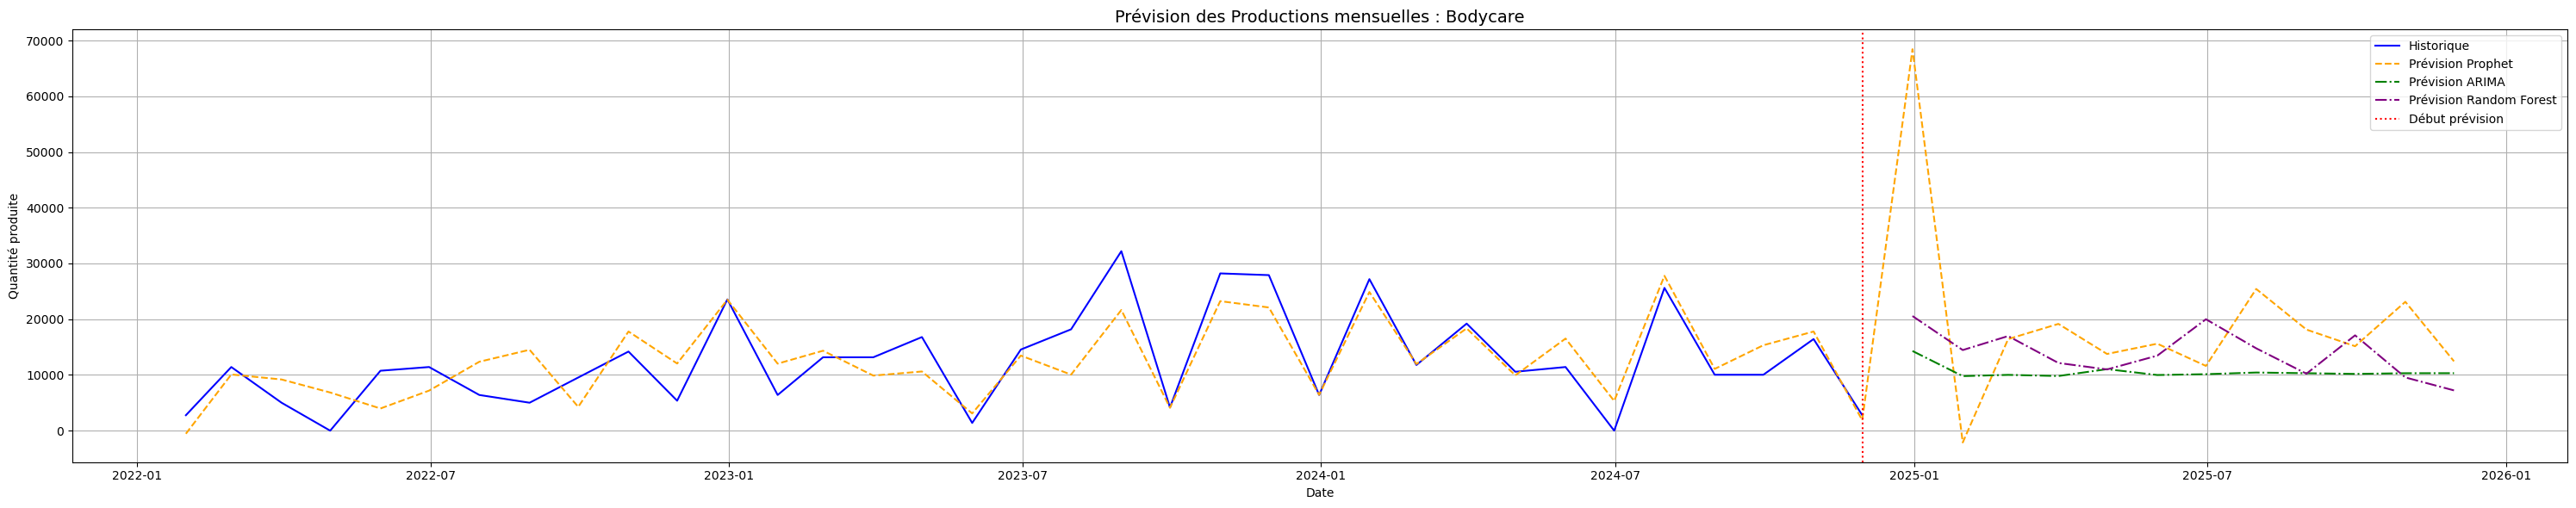

17:19:02 - cmdstanpy - INFO - Chain [1] start processing



📊 Catégorie : Haircare


17:19:02 - cmdstanpy - INFO - Chain [1] done processing


🔮 Prophet → MAE: 9698.09 | RMSE: 12651.88 | R²: 0.72
📈 ARIMA  → MAE: 22363.76 | RMSE: 28700.49 | R²: -0.44
📊 RF      → MAE: 7782.63 | RMSE: 9987.11 | R²: 0.83


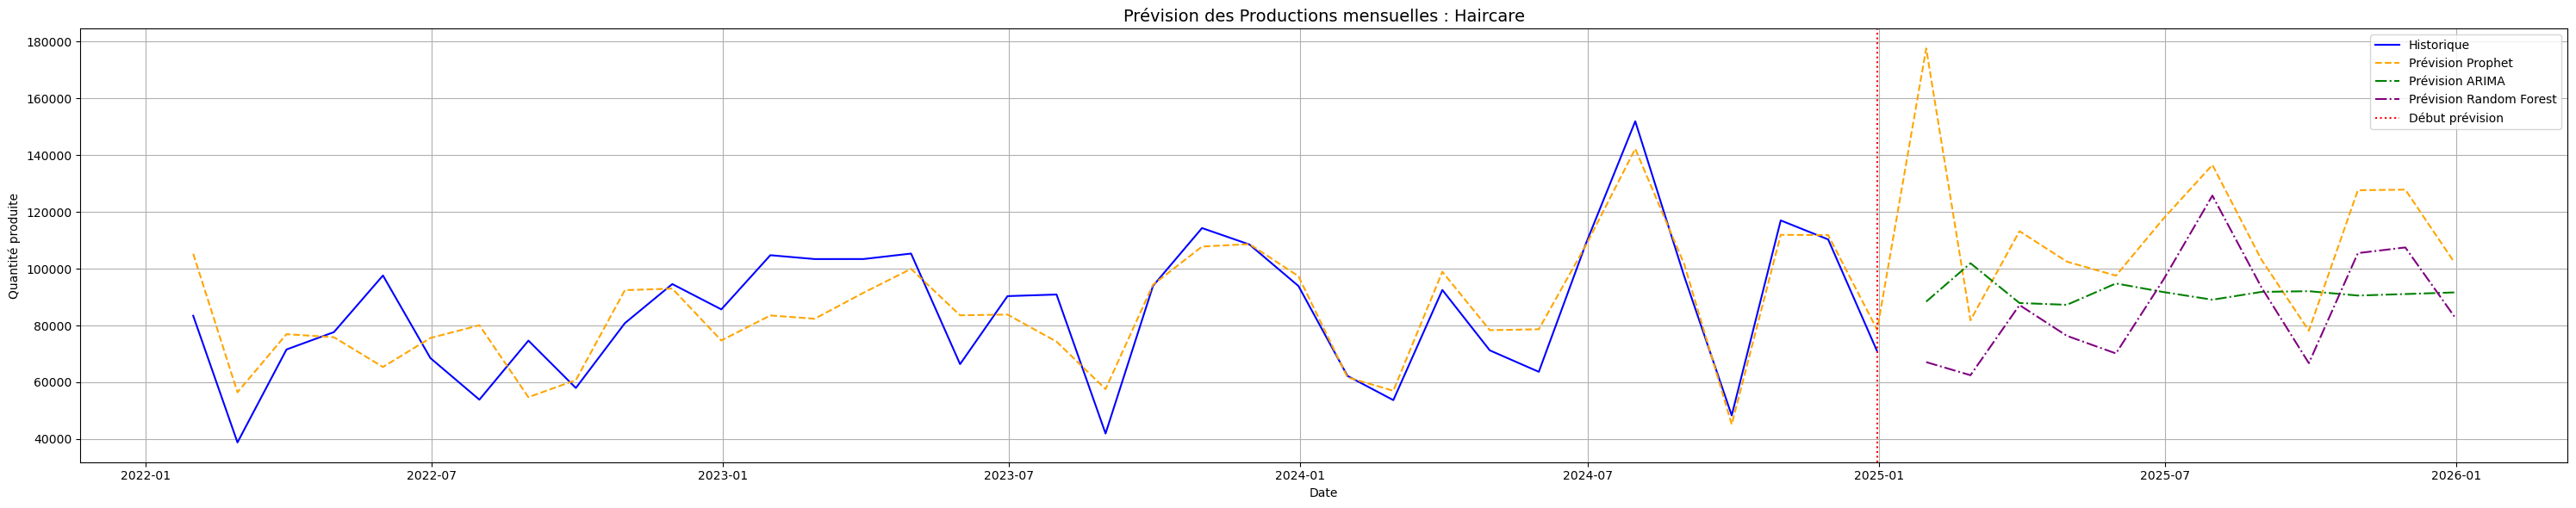

17:19:03 - cmdstanpy - INFO - Chain [1] start processing



📊 Catégorie : Makeup


17:19:03 - cmdstanpy - INFO - Chain [1] done processing


🔮 Prophet → MAE: 14678.84 | RMSE: 19554.04 | R²: 0.70
📈 ARIMA  → MAE: 39599.80 | RMSE: 53862.41 | R²: -1.27
📊 RF      → MAE: 11403.90 | RMSE: 15186.85 | R²: 0.82


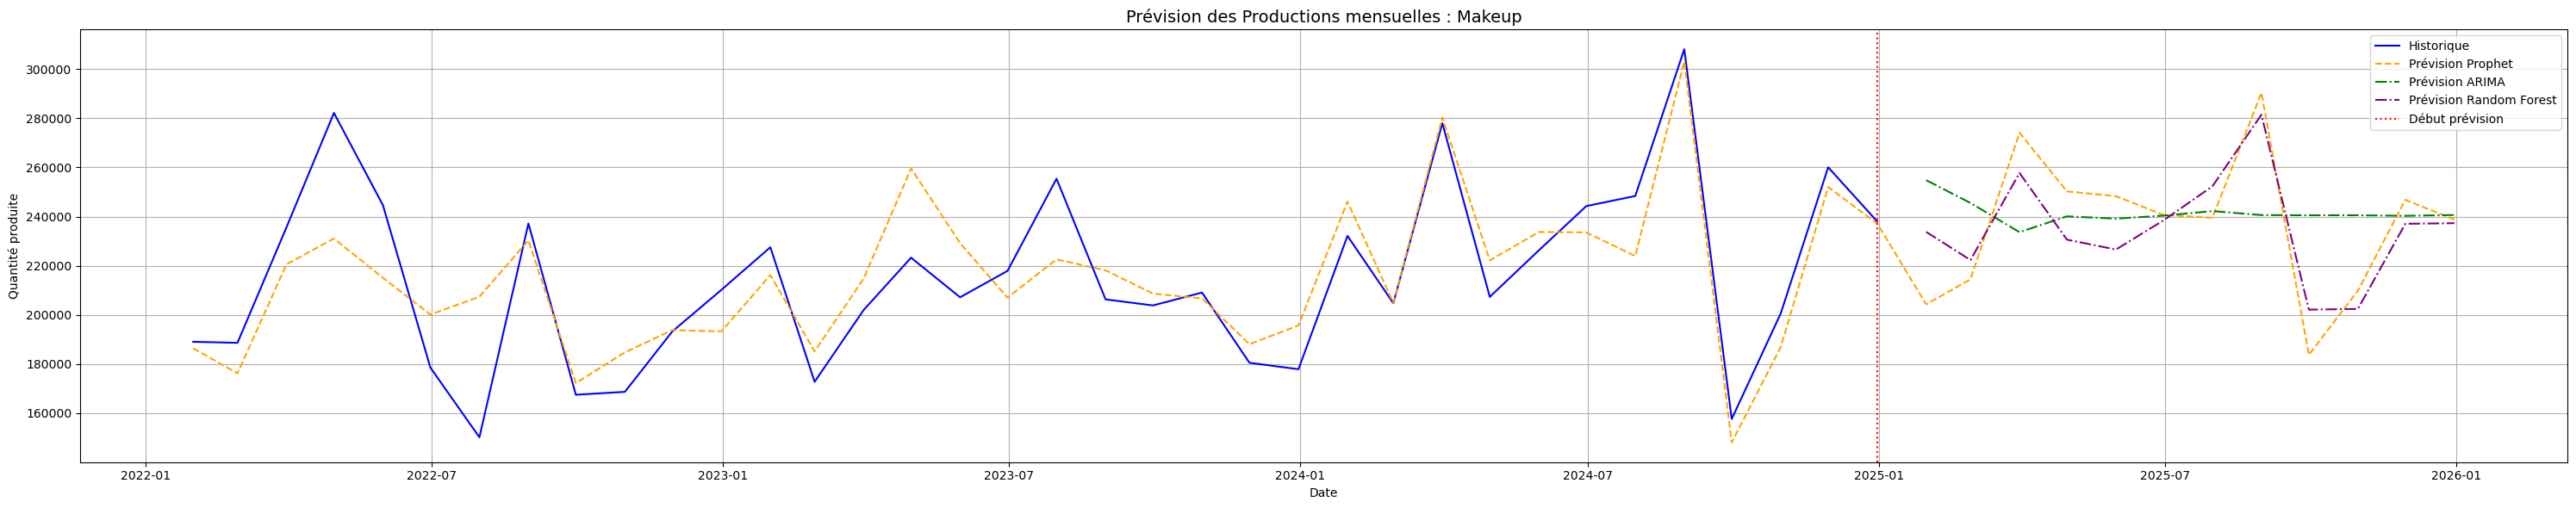

17:19:03 - cmdstanpy - INFO - Chain [1] start processing



📊 Catégorie : Skincare


17:19:04 - cmdstanpy - INFO - Chain [1] done processing


🔮 Prophet → MAE: 6009.55 | RMSE: 7419.22 | R²: 0.51
📈 ARIMA  → MAE: 8367.29 | RMSE: 10729.66 | R²: -0.02
📊 RF      → MAE: 3207.21 | RMSE: 4043.83 | R²: 0.86


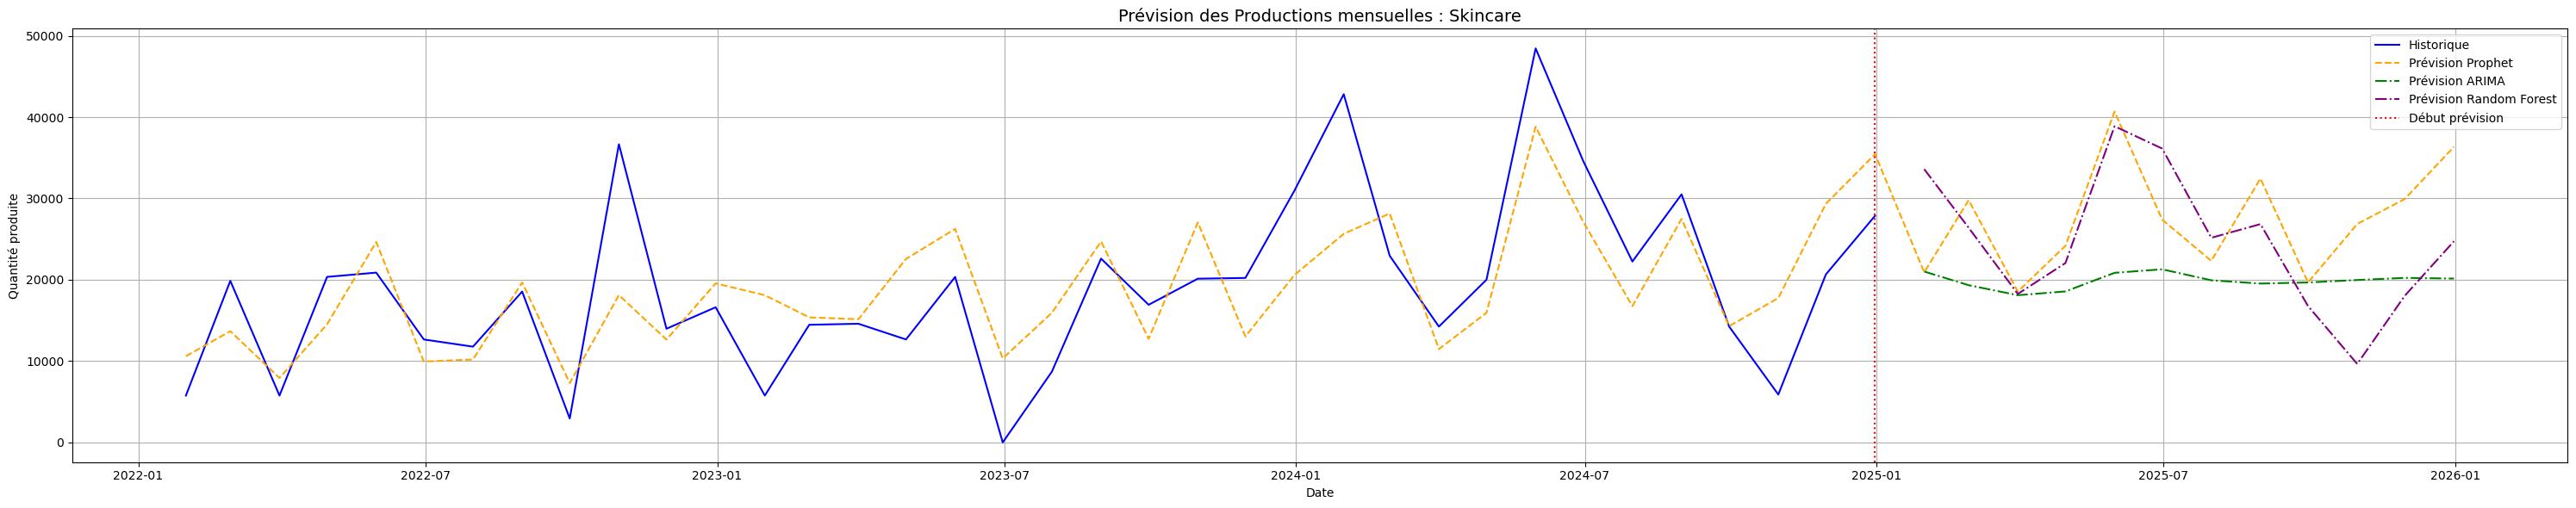

17:19:04 - cmdstanpy - INFO - Chain [1] start processing



📊 Catégorie : Fragrance


17:19:04 - cmdstanpy - INFO - Chain [1] done processing


🔮 Prophet → MAE: 1357.57 | RMSE: 1749.36 | R²: 0.84
📈 ARIMA  → MAE: 3237.14 | RMSE: 4294.52 | R²: 0.03
📊 RF      → MAE: 565.66 | RMSE: 1280.04 | R²: 0.91


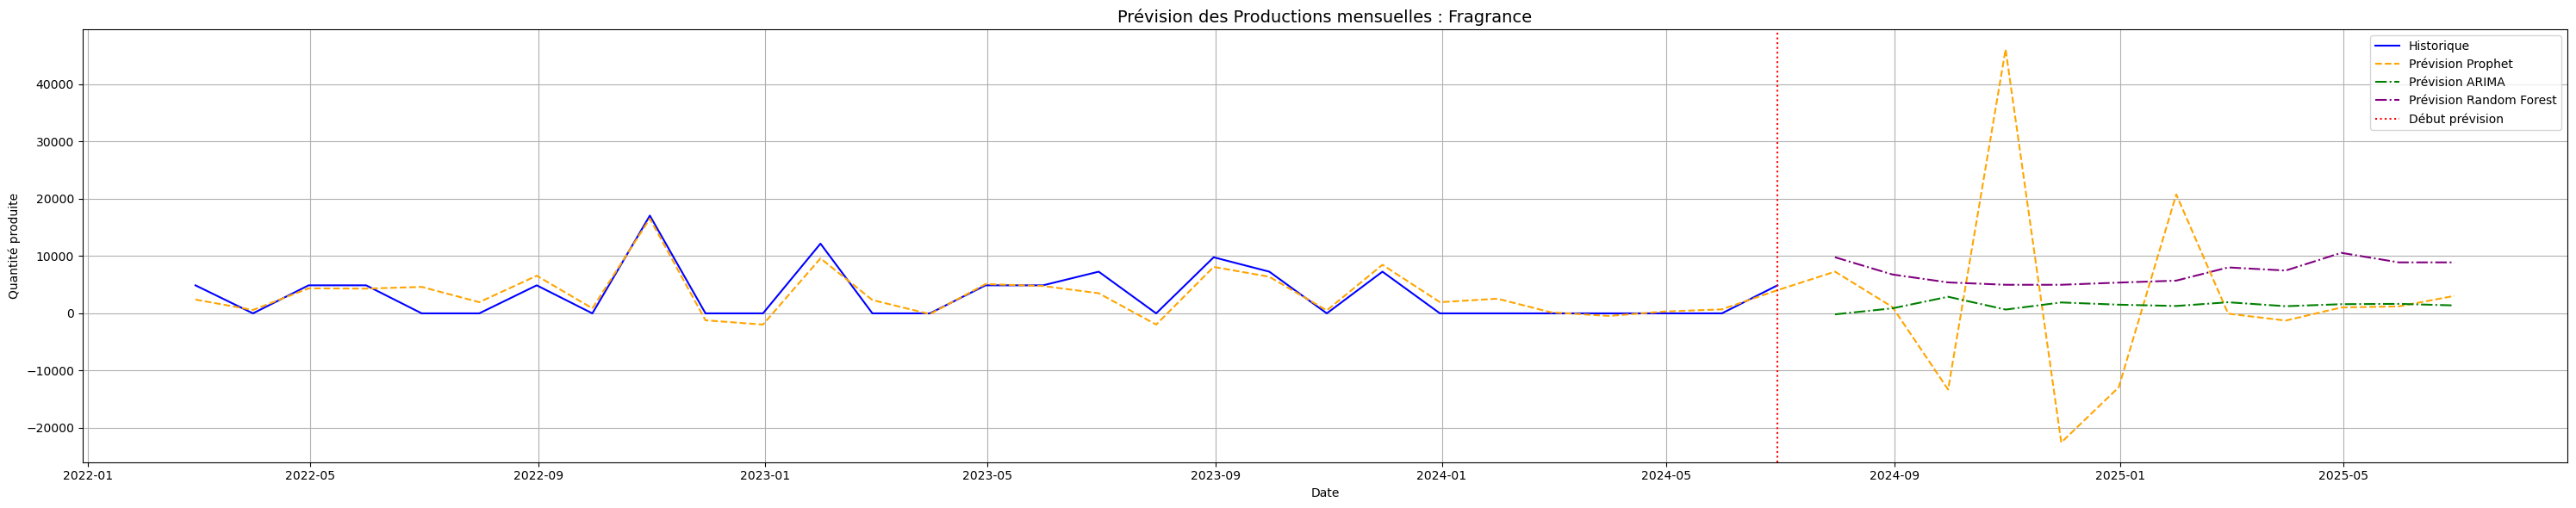

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from prophet import Prophet
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

# 📡 Connexion SQL
server = 'DESKTOP-OQ959SK'
database = 'FinalDW'
conn_str = f'mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(conn_str)

# 📥 Requête SQL pour quantité produite par jour et par catégorie
query = """
SELECT 
    D.Year,
    D.Month,
    C.Category,
    SUM(FW.Quantity) AS Total_Quantite_Produite
FROM Fact_Warehousing FW
JOIN Fact_Production FP ON FW.Prod_FK = FP.Product_PK
JOIN Dim_Product P ON FP.Product_PK = P.Product_PK
JOIN Dim_Category C ON P.Category_FK = C.Category_PK
JOIN Dim_Date D ON FP.ProductionStartDate_PK = D.Date_PK
WHERE D.Year IS NOT NULL AND D.Month IS NOT NULL
GROUP BY D.Year, D.Month, C.Category
ORDER BY D.Year, D.Month, C.Category;
"""

# Lire les données de la base de données SQL
df = pd.read_sql(query, engine)
df['Full_Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))  # Crée une colonne Full_Date avec 1er du mois
print(df)

# 🔁 Pour chaque catégorie
for cat in df['Category'].unique():
    print(f"\n📊 Catégorie : {cat}")
    
    df_cat = df[df['Category'] == cat].copy()
    df_cat = df_cat.resample('M', on='Full_Date').sum().reset_index()  # Resample les données par mois
    
    if len(df_cat) < 24:
        print("⚠️ Pas assez de données.")
        continue

    # --- Prophet ---
    df_prophet = df_cat.rename(columns={'Full_Date': 'ds', 'Total_Quantite_Produite': 'y'})
    model_prophet = Prophet(yearly_seasonality=True)
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=12, freq='M')
    forecast_prophet = model_prophet.predict(future)
    df_merge_prophet = pd.merge(df_prophet, forecast_prophet[['ds', 'yhat']], on='ds')
    mae_prophet = mean_absolute_error(df_merge_prophet['y'], df_merge_prophet['yhat'])
    rmse_prophet = np.sqrt(mean_squared_error(df_merge_prophet['y'], df_merge_prophet['yhat']))
    r2_prophet = r2_score(df_merge_prophet['y'], df_merge_prophet['yhat'])

    # --- ARIMA ---
    train_arima = df_cat.copy()
    train_arima.set_index('Full_Date', inplace=True)
    model_arima = ARIMA(train_arima['Total_Quantite_Produite'], order=(5, 1, 0))  # Exemple d'ARIMA (5,1,0)
    results_arima = model_arima.fit()

    forecast_arima = results_arima.forecast(steps=12)
    index_future = pd.date_range(start=train_arima.index.max() + pd.DateOffset(months=1), periods=12, freq='M')
    forecast_arima_df = pd.DataFrame({'ds': index_future, 'yhat_arima': forecast_arima})

    # Évaluation ARIMA (sur données connues)
    pred_known_arima = results_arima.predict(start=train_arima.index[0], end=train_arima.index[-1])
    mae_arima = mean_absolute_error(train_arima['Total_Quantite_Produite'], pred_known_arima)
    rmse_arima = np.sqrt(mean_squared_error(train_arima['Total_Quantite_Produite'], pred_known_arima))
    r2_arima = r2_score(train_arima['Total_Quantite_Produite'], pred_known_arima)

    # --- Random Forest ---
    # Préparation des données pour Random Forest
    df_cat['Month_Num'] = df_cat['Full_Date'].dt.month
    X_rf = df_cat[['Year', 'Month_Num']]
    y_rf = df_cat['Total_Quantite_Produite']
    rf_model = RandomForestRegressor(n_estimators=100)
    rf_model.fit(X_rf, y_rf)

    # Prévisions Random Forest
    future_months = pd.DataFrame({'Year': [df_cat['Year'].iloc[-1]] * 12, 'Month_Num': list(range(1, 13))})
    forecast_rf = rf_model.predict(future_months)

    # Créer un DataFrame pour les prévisions Random Forest
    forecast_rf_df = pd.DataFrame({'ds': index_future, 'yhat_rf': forecast_rf})

    # Évaluation Random Forest (sur données connues)
    mae_rf = mean_absolute_error(y_rf, rf_model.predict(X_rf))
    rmse_rf = np.sqrt(mean_squared_error(y_rf, rf_model.predict(X_rf)))
    r2_rf = r2_score(y_rf, rf_model.predict(X_rf))

    print(f"🔮 Prophet → MAE: {mae_prophet:.2f} | RMSE: {rmse_prophet:.2f} | R²: {r2_prophet:.2f}")
    print(f"📈 ARIMA  → MAE: {mae_arima:.2f} | RMSE: {rmse_arima:.2f} | R²: {r2_arima:.2f}")
    print(f"📊 RF      → MAE: {mae_rf:.2f} | RMSE: {rmse_rf:.2f} | R²: {r2_rf:.2f}")

    # --- Graphique comparatif ---
    plt.figure(figsize=(30, 6))
    plt.plot(df_cat['Full_Date'], df_cat['Total_Quantite_Produite'], label='Historique', color='blue')
    plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prévision Prophet', color='orange', linestyle='--')
    plt.plot(forecast_arima_df['ds'], forecast_arima_df['yhat_arima'], label='Prévision ARIMA', color='green', linestyle='-.')
    plt.plot(forecast_rf_df['ds'], forecast_rf_df['yhat_rf'], label='Prévision Random Forest', color='purple', linestyle='-.')
    plt.axvline(df_cat['Full_Date'].max(), color='red', linestyle=':', label='Début prévision')
    plt.title(f"Prévision des Productions mensuelles : {cat}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Quantité produite")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
